In [1]:
import warnings
from math import pi

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.polynomial.polynomial import Polynomial
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')


# 1. Setup

## Data loading and definitions

In [13]:
# Load the data
df = pd.read_csv('data/Sample_4.csv')

# List of object columns
dyestuff_cols = [
    'green_dyestuff',
    'ruby_red_dyestuff',
    'black_dyestuff',
    'purple_dyestuff',
    'yellow_dyestuff',
]

weapons_and_armor_cols = [
    'arcus',
    'ballista',
    'bassinetus',
    'bloquerius',
    'brassaletus',
    'caliga',
    'camallia',
    'camberia',
    'capellus',
    'carcays',
    'chavarina',
    'cirotheca',
    'clipeus',
    'curassia',
    'elma',
    'ensis',
    'gantelletus',
    'gladius',
    'gorjerium',
    'lanceus',
    'lorica',
    'manutecha',
    'massa',
    'panseria',
    'pavesius',
    'plata',
    'rudella',
    'scutum',
    'servelleria',
    'sotulares_ferreos',
    'spontonum',
    'targia',
]

cushions_cols = [
    'pulvinar',
    'coysin',
    'auricula',
    'fluna',
    'transverser',
]

exotic_cols = [
    'silk',
    'sendal',
    'alexandria',
    'damascus',
    'amber',
]

other_objects_cols = [
    'cushions',
    'mortars',
    'dough_troughs',
    'candelabra',
    'spits',
    'lamps',
    'decorative_gold',
    'alembics',
]

object_cols = [
    *other_objects_cols,
    *dyestuff_cols,
    *exotic_cols,
]

full_object_cols = [
    *object_cols,
    *weapons_and_armor_cols,
    *cushions_cols,
]

temp_cols = [
    'bwe_object_points',
    'bwe_all_linens',
    'bwe_linen_points',
    'bwe_all_exotic',
    'bwe_exotic_points',
    'bwe_all_dyestuffs',
    'bwe_dyestuff_points',
    'bwe_all_arms_armor',
    'bwe_arms_armor_points',
]

date_groupings = {
    '1250-1299': range(1250, 1300),
    '1300-1349': range(1300, 1350),
    '1350-1399': range(1350, 1400),
    '1400-1449': range(1400, 1450),
}

faith_encodings = {
    'Christian': 0,
    'Jew': 1,
}

gender_encodings = {
    'Male': 0,
    'Female': 1,
}


## Data manipulation

In [ ]:
# add unique id
df['id'] = df.index

# drop temporary columns
df.drop(columns=temp_cols, inplace=True, errors='ignore')

# remove cardinality suffixes (i.e. st, rd, th) from estimated_wealth_quartile
df['estimated_wealth_quartile'] = df['estimated_wealth_quartile'].str.replace(r'(\d+)(st|nd|rd|th)', r'\1', regex=True)

# Replace NaN values in columns with 0 and convert to integers
target_cols = [
    'total_tablecloths',
    'total_bedsheets',
    'total_tunics',
    'object_phrases',
    'estimated_wealth_points',
    'estimated_wealth_quartile',
    *full_object_cols,
]
df[target_cols] = df[target_cols].fillna(0).astype(int)

# add presence/absence columns for tablecloths, bedsheets, and tunics based on the totals
df['tablecloths'] = df['total_tablecloths'].apply(lambda x: 1 if x > 0 else 0)
df['bedsheets'] = df['total_bedsheets'].apply(lambda x: 1 if x > 0 else 0)
df['tunics'] = df['total_tunics'].apply(lambda x: 1 if x > 0 else 0)

# add presence/absence column for linens combined
df['linens'] = df[['tablecloths', 'bedsheets', 'tunics']].apply(lambda x: 1 if any(x > 0) else 0, axis=1)

linen_cols = ['tablecloths', 'bedsheets', 'tunics']

# add presence/absence column for weapons and armor based on the weapons_and_armor_cols
df['weapons'] = df[weapons_and_armor_cols].apply(lambda x: 1 if any(x > 0) else 0, axis=1)

# add 'var_weapons' as sum of all weapons and armor columns, indicating strength of weapons and armor variability
df['var_weapons'] = df[weapons_and_armor_cols].sum(axis=1)

# add 'var_exotic' as sum of all luxury object columns
df['var_exotic'] = df[exotic_cols].sum(axis=1)

# add 'var_dyestuff' as sum of all dyestuffs columns
df['var_dyestuff'] = df[dyestuff_cols].sum(axis=1)

# add the new columns to the object_cols list
object_cols.extend(['weapons', 'linens'])
full_object_cols.extend(['weapons', 'linens', 'var_weapons', *linen_cols])

# encode faith and gender
df['faith'] = df['faith'].map(faith_encodings)
df['gender_decedent'] = df['gender_decedent'].map(gender_encodings)

# Melt to long format
df_long = df.melt(
    id_vars=['id', 'date_group', 'object_phrases'],
    value_vars=object_cols,
    var_name='object_type',
    value_name='present',
)
df_long_full = df.melt(
    id_vars=['id', 'date_group', 'object_phrases'],
    value_vars=full_object_cols,
    var_name='object_type',
    value_name='present',
)

# Group by date_group and object_type
dategroup = df_long.groupby(['date_group', 'object_type'])['present'].sum().unstack(fill_value=0)
dategroup_full = df_long_full.groupby(['date_group', 'object_type'])['present'].sum().unstack(fill_value=0)


In [15]:
display(df_long)

,id,date_group,object_phrases,object_type,present
0,0,1250-1299,59,cushions,1
1,1,1250-1299,149,cushions,1
2,2,1250-1299,280,cushions,1
3,3,1250-1299,8,cushions,1
4,4,1250-1299,41,cushions,1
...,...,...,...,...,...
1715,81,1400-1449,226,linens,1
1716,82,1400-1449,120,linens,0
1717,83,1400-1449,44,linens,1
1718,84,1400-1449,67,linens,1


# 2. Dataset Exploration

## General overview

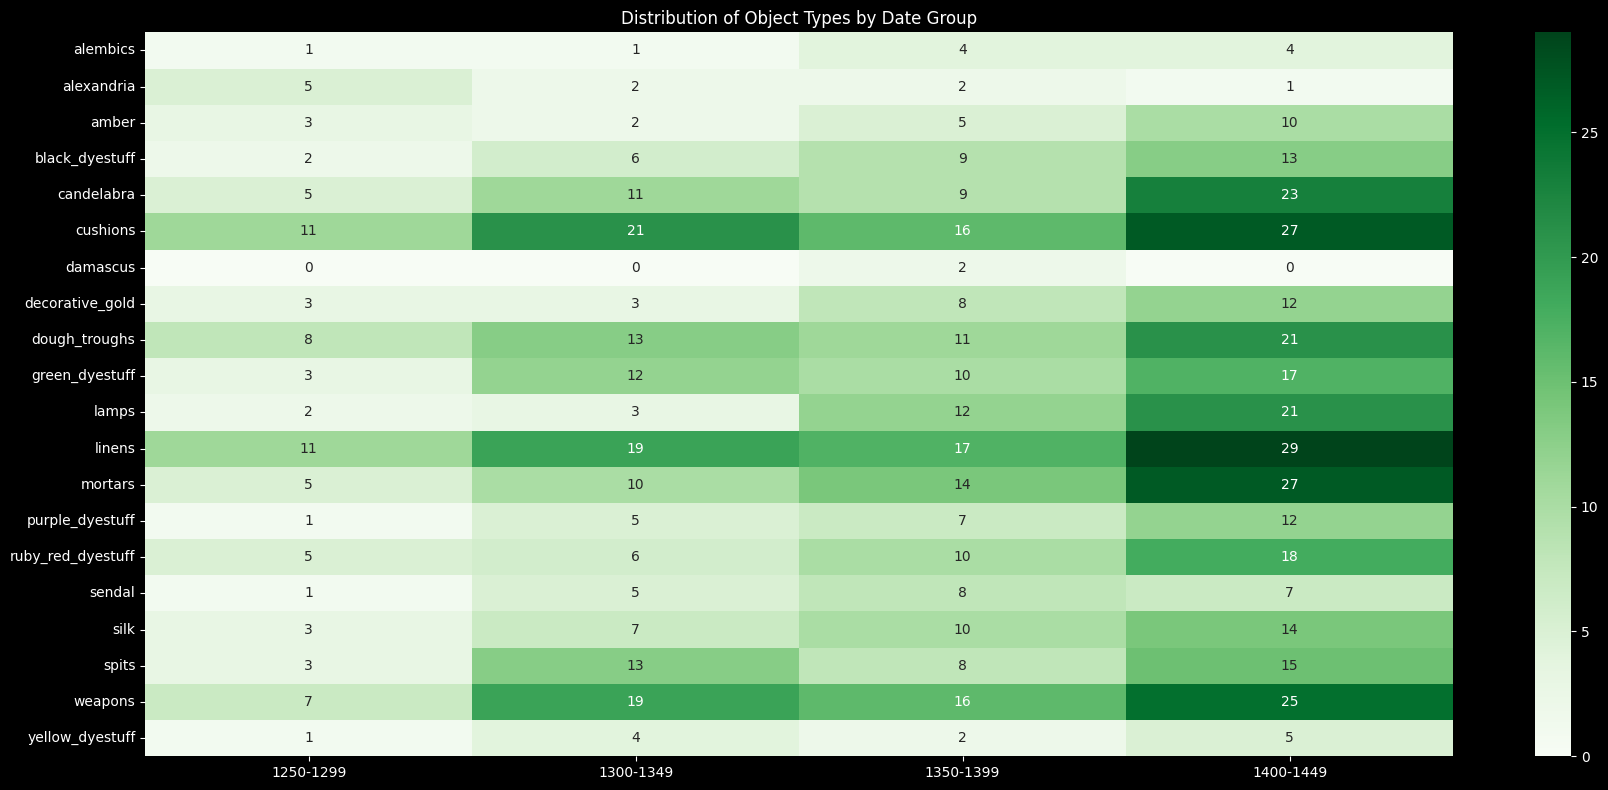

In [16]:
# Plot heatmap for date_group vs object_type
plt.figure(figsize=(18, 8))
sns.heatmap(dategroup.T, cmap='Greens', annot=True, fmt='d')
plt.title('Distribution of Object Types by Date Group')
plt.xlabel(None)
plt.ylabel(None)
plt.tight_layout()
plt.show()

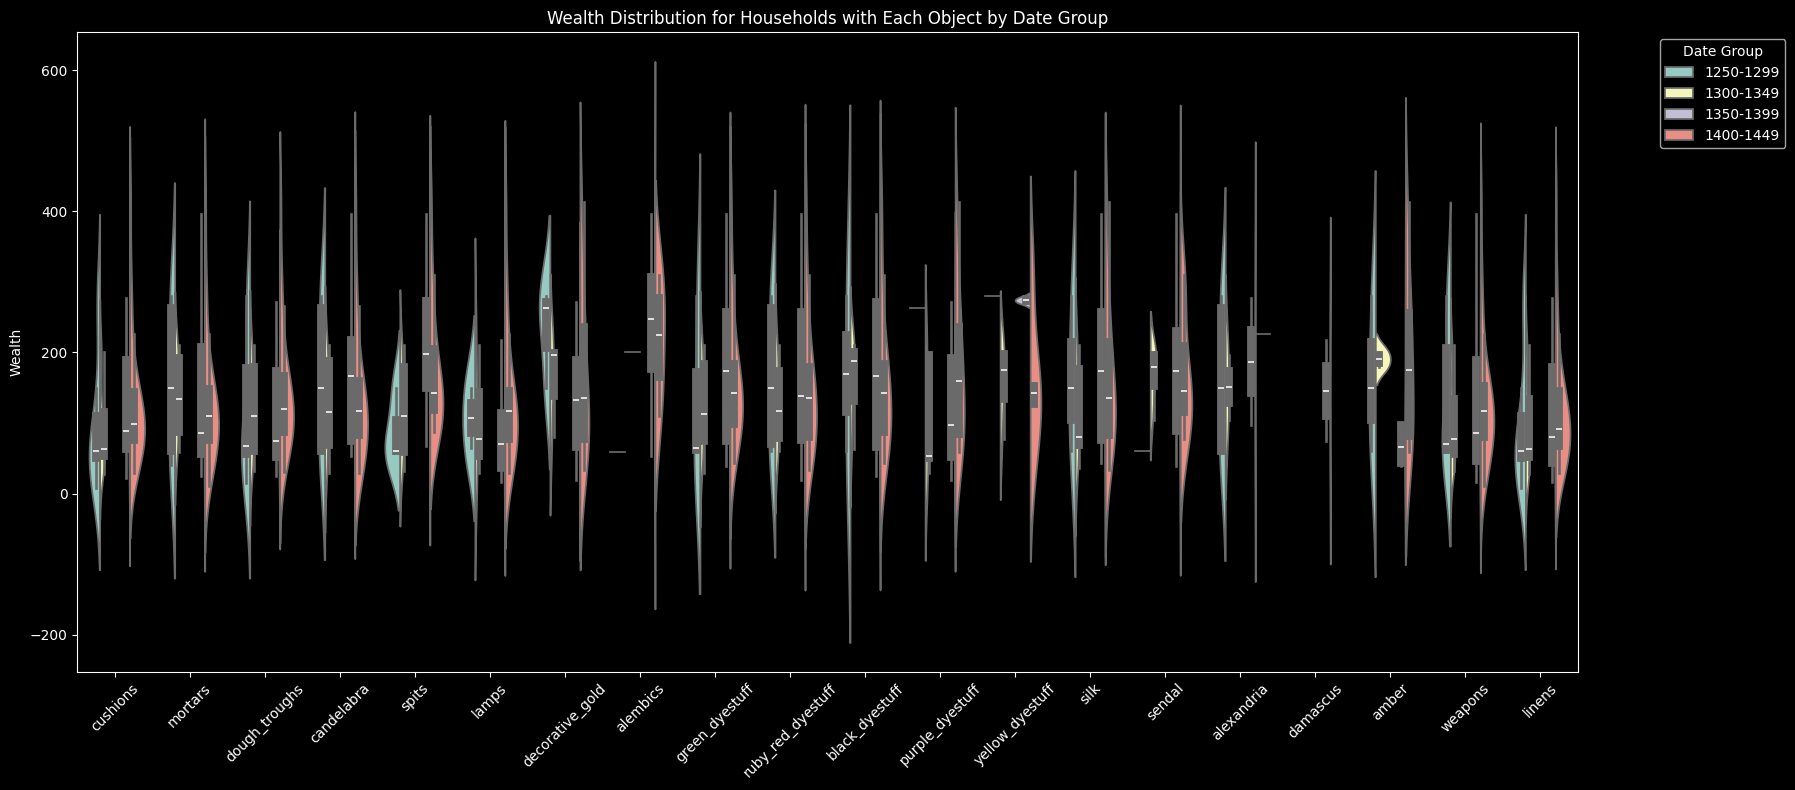

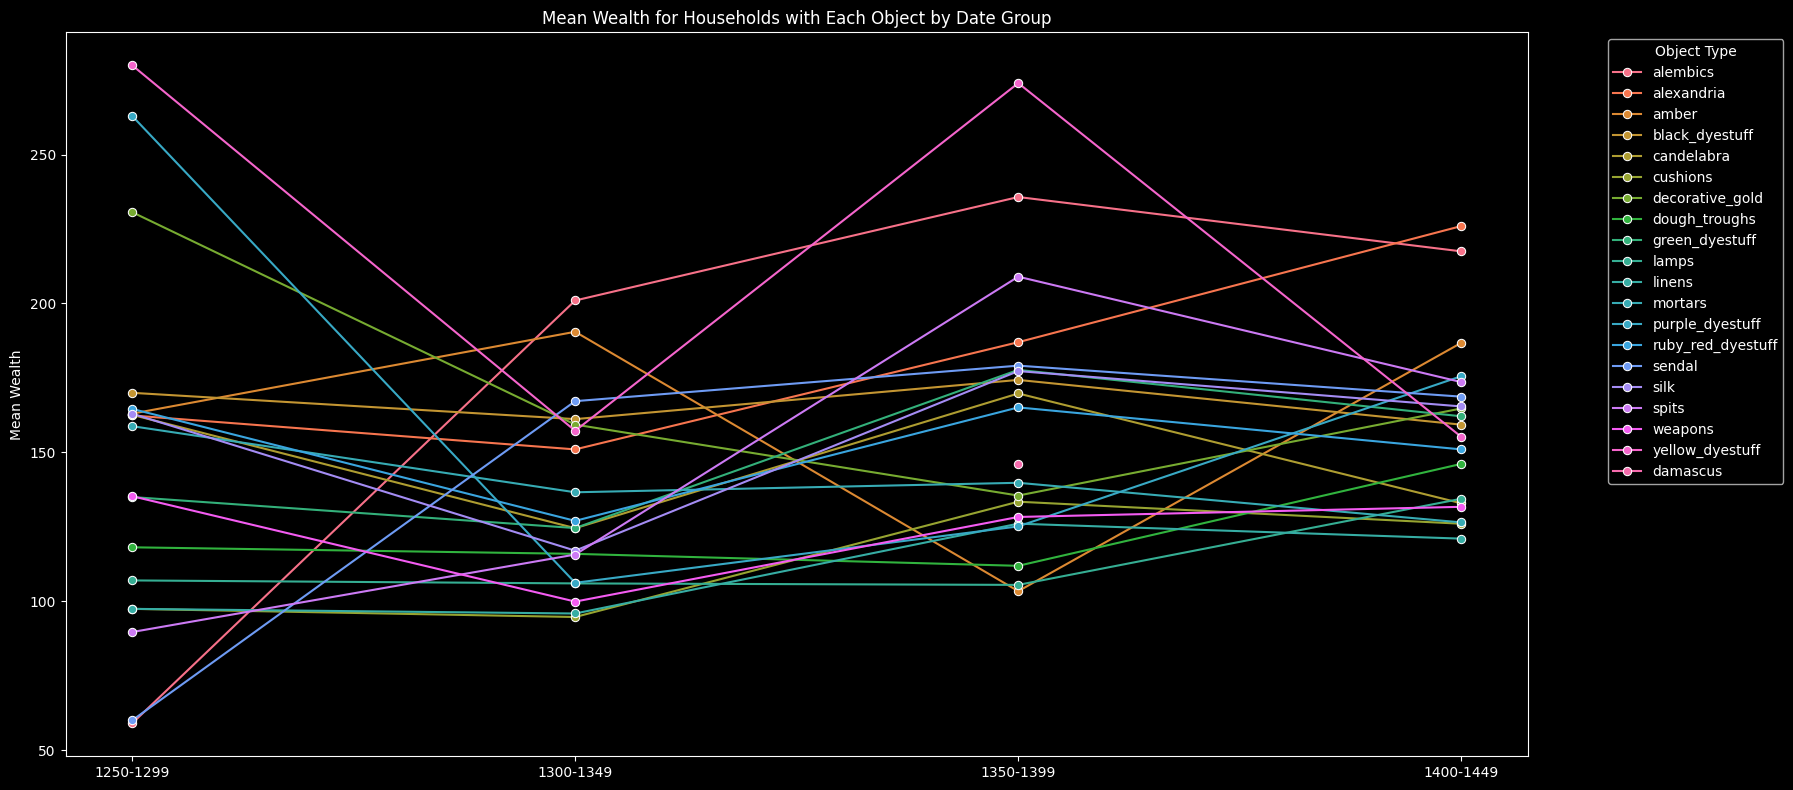

In [17]:
# Violin plot: Wealth distribution for households with each object, grouped by date_group
plt.figure(figsize=(18, 8))
sns.violinplot(data=df_long[df_long['present'] == 1], x='object_type', y='object_phrases', hue='date_group', split=True)
plt.title('Wealth Distribution for Households with Each Object by Date Group')
plt.xlabel(None)
plt.ylabel('Wealth')
plt.xticks(rotation=45)
plt.legend(title='Date Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Lineplot: Mean wealth for households with each object, by date_group
mean_wealth = (
    df_long[df_long['present'] == 1].groupby(['date_group', 'object_type'])['object_phrases'].mean().reset_index()
)
plt.figure(figsize=(18, 8))
sns.lineplot(data=mean_wealth, x='date_group', y='object_phrases', hue='object_type', marker='o')
plt.title('Mean Wealth for Households with Each Object by Date Group')
plt.xlabel(None)
plt.ylabel('Mean Wealth')
plt.legend(title='Object Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

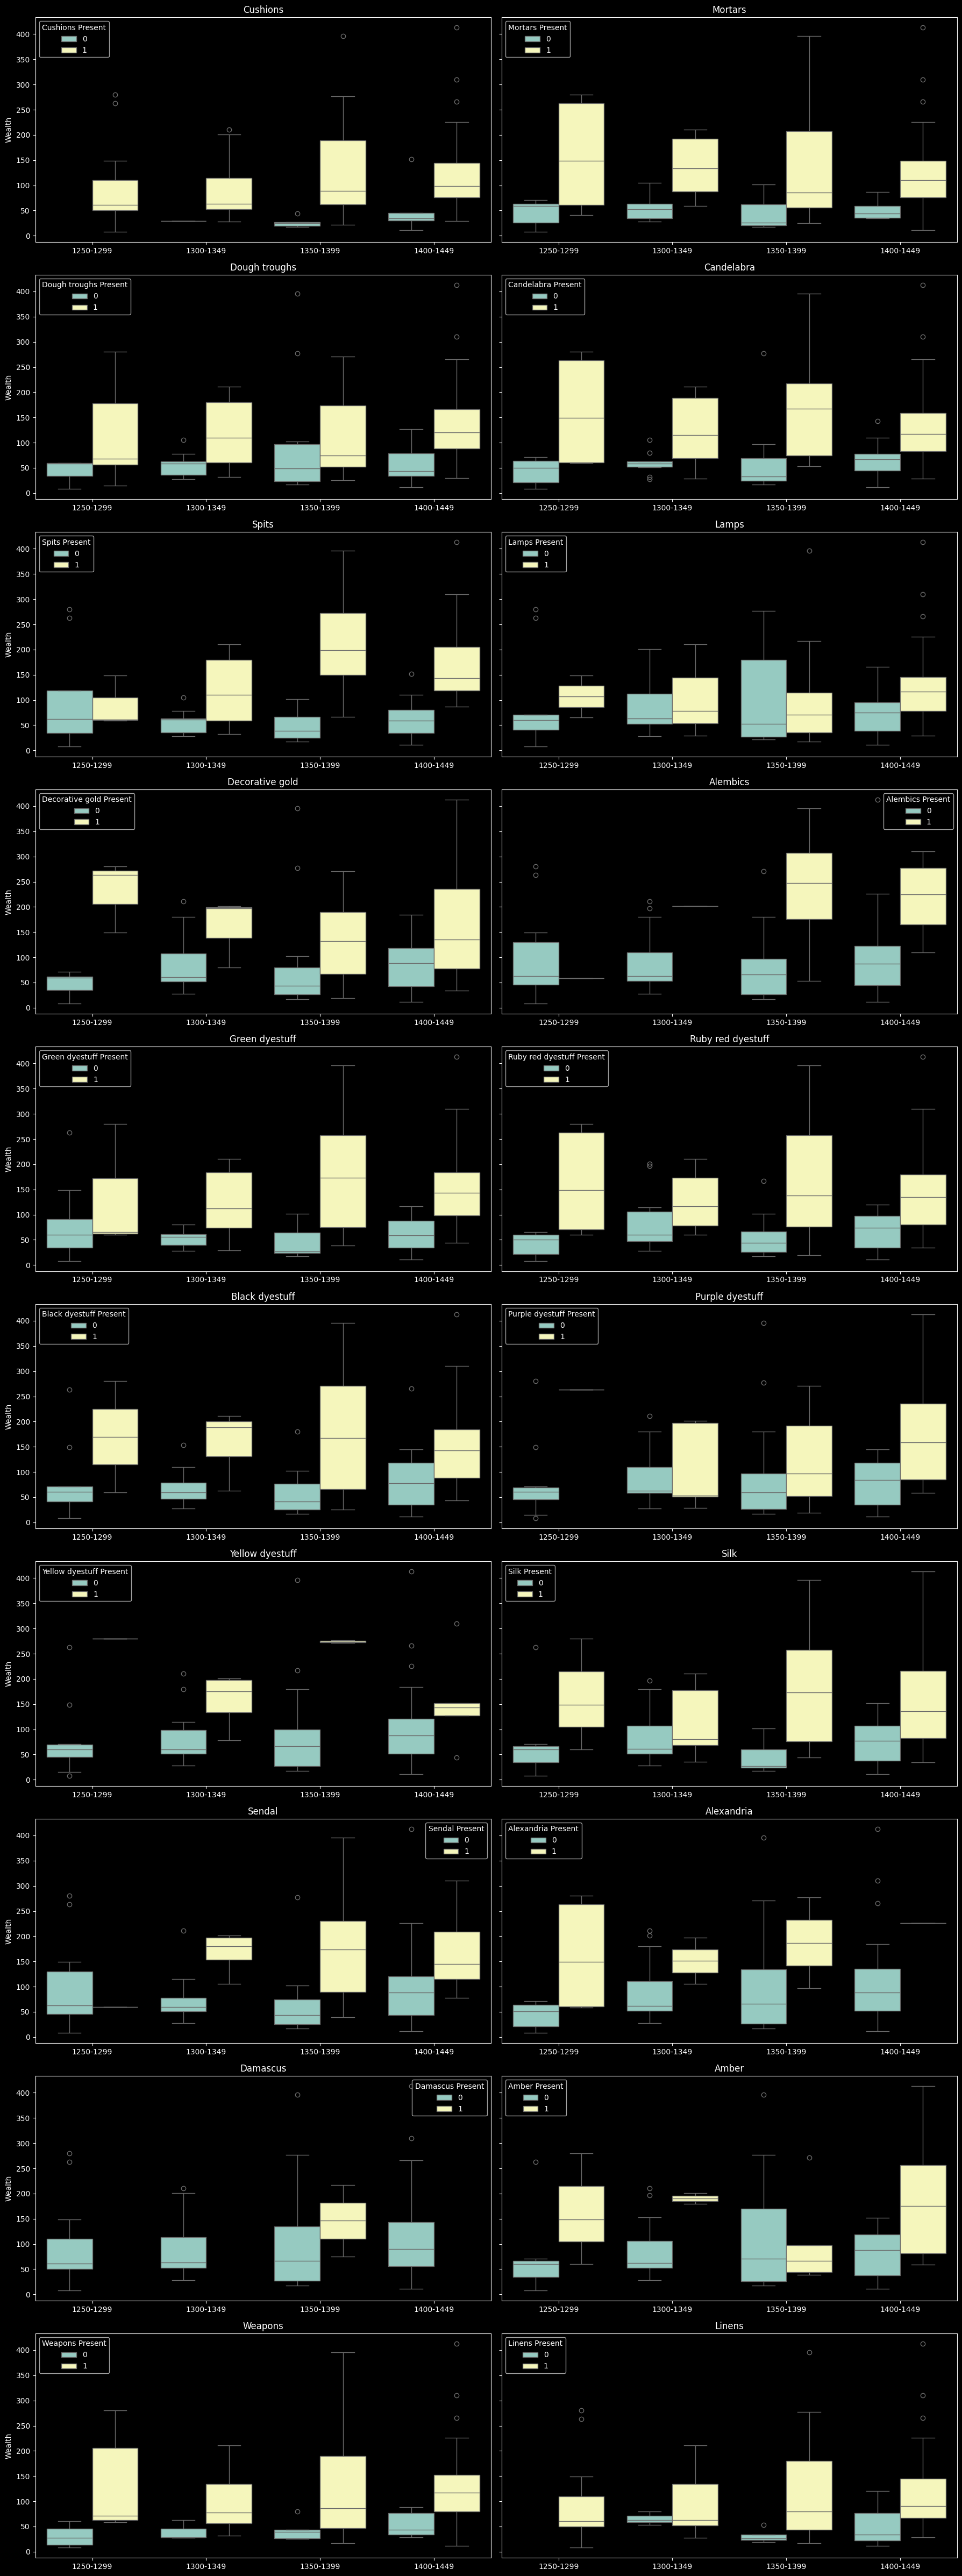

In [18]:
# Boxplots: wealth by object presence (1/0) grouped by date_group
rows = round(len(object_cols) / 2)
fig, axes = plt.subplots(ncols=2, nrows=rows, figsize=(18, 48), sharey=True)
for ax, object_type in zip(axes.flatten(), object_cols):
    sns.boxplot(
        data=df_long[df_long['object_type'] == object_type],
        x='date_group',
        y='object_phrases',
        hue='present',
        ax=ax,
    )
    obj_name = object_type.replace('_', ' ').capitalize()
    ax.set_title(obj_name)
    ax.set_xlabel(None)
    ax.set_ylabel('Wealth')
    ax.legend(title=f'{obj_name} Present')
plt.tight_layout()
plt.show()


# 3. Analysis

## Definitions 

Unless otherwise indicated, correlations are calculated using the [*Pearson correlation coefficient*](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient).

The **correlation coefficient** measures the strength and direction of the relationship between samples. Values close to `+1` indicate a strong positive correlation, values close to `-1` indicate a strong negative correlation, while values near `0` suggest no significant relationship.

The **p-values** indicate the statistical significance of the correlation: less than `0.05` typically suggests the correlation is statistically significant, while higher p-values indicate weaker evidence against the null hypothesis (*i.e.* no correlation).

## Does the presence and quantity of textiles correlate to the number of object phrases (used as proxy for household wealth)?


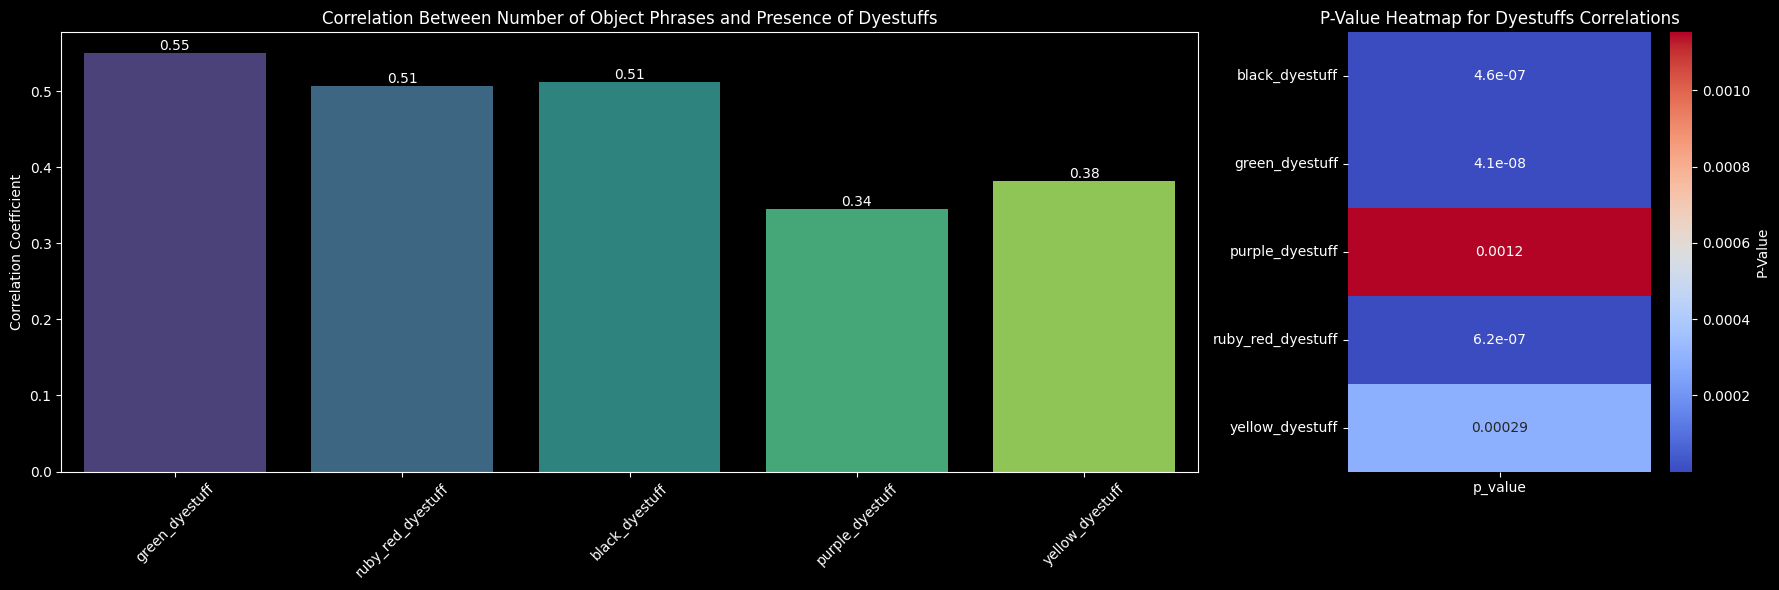

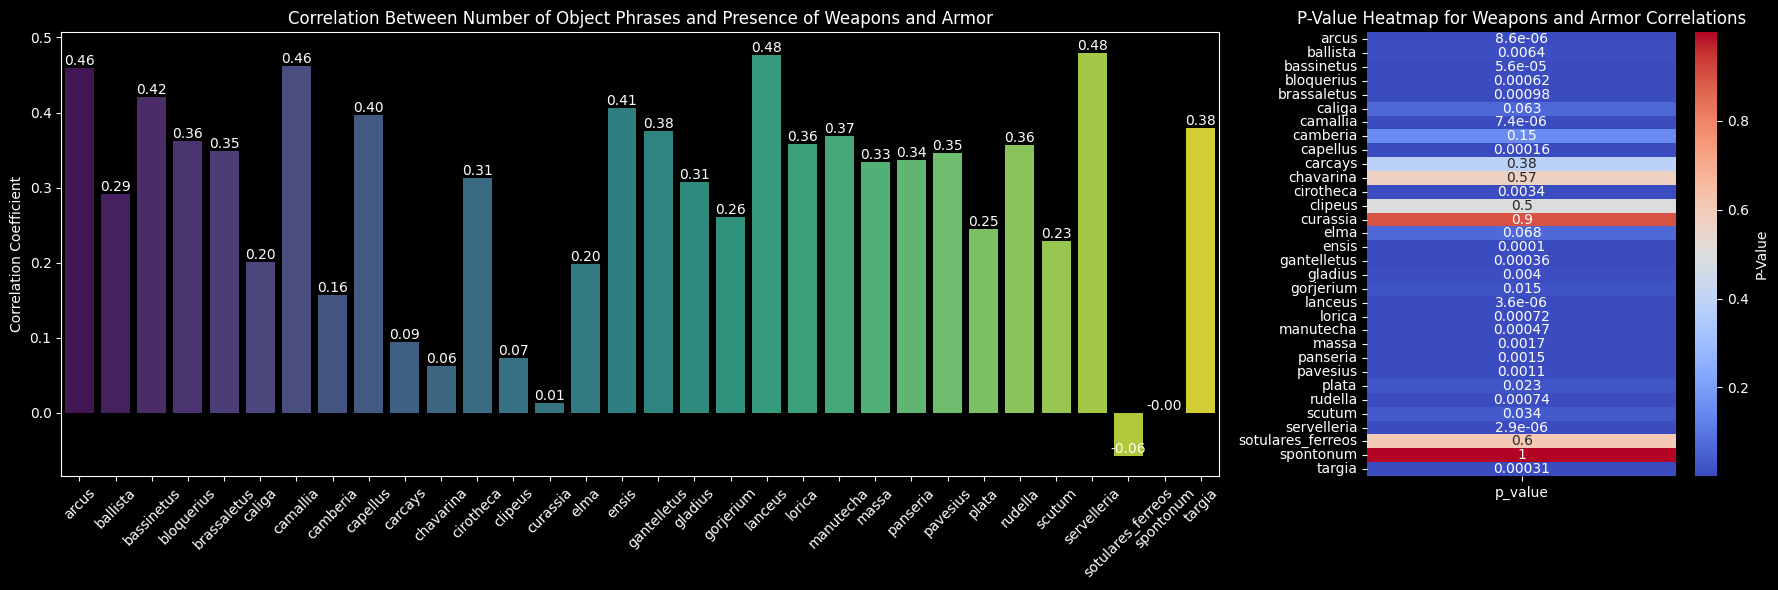

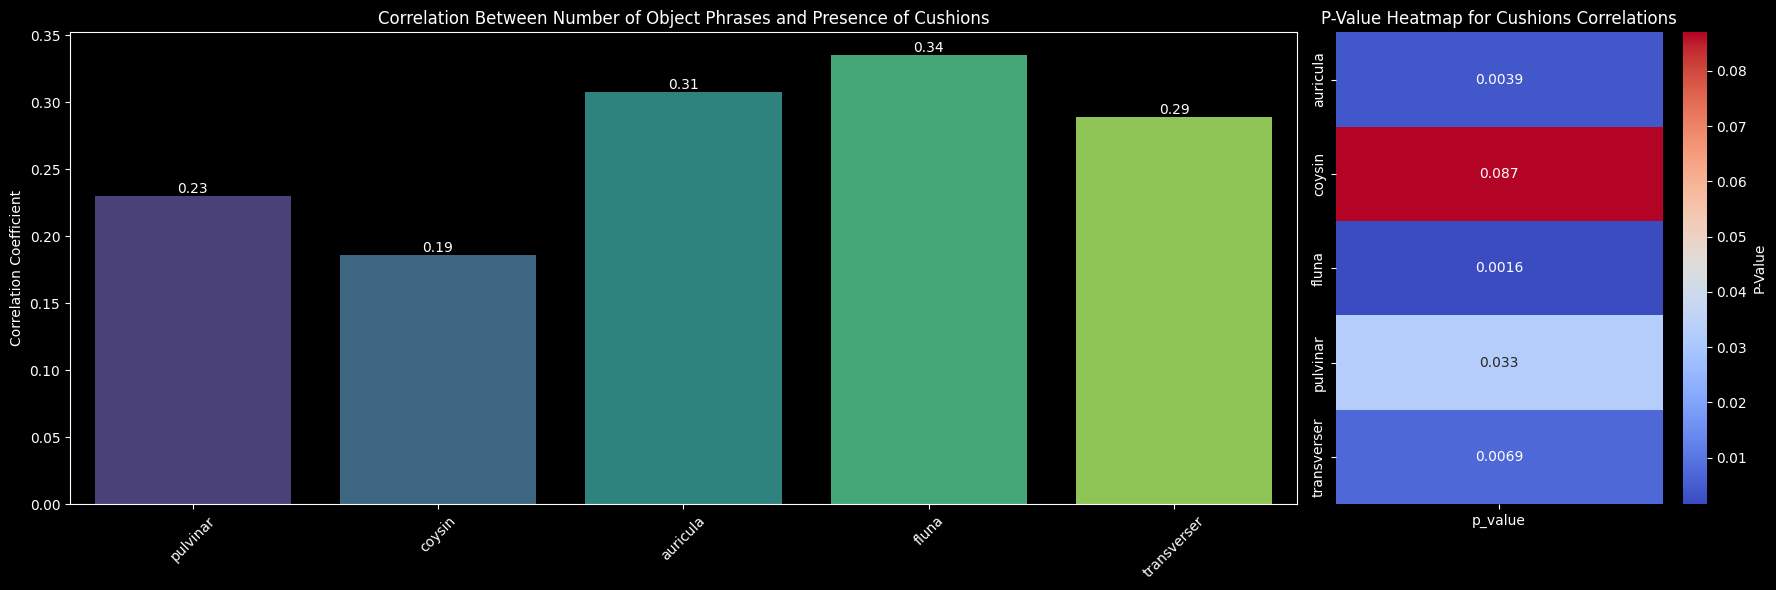

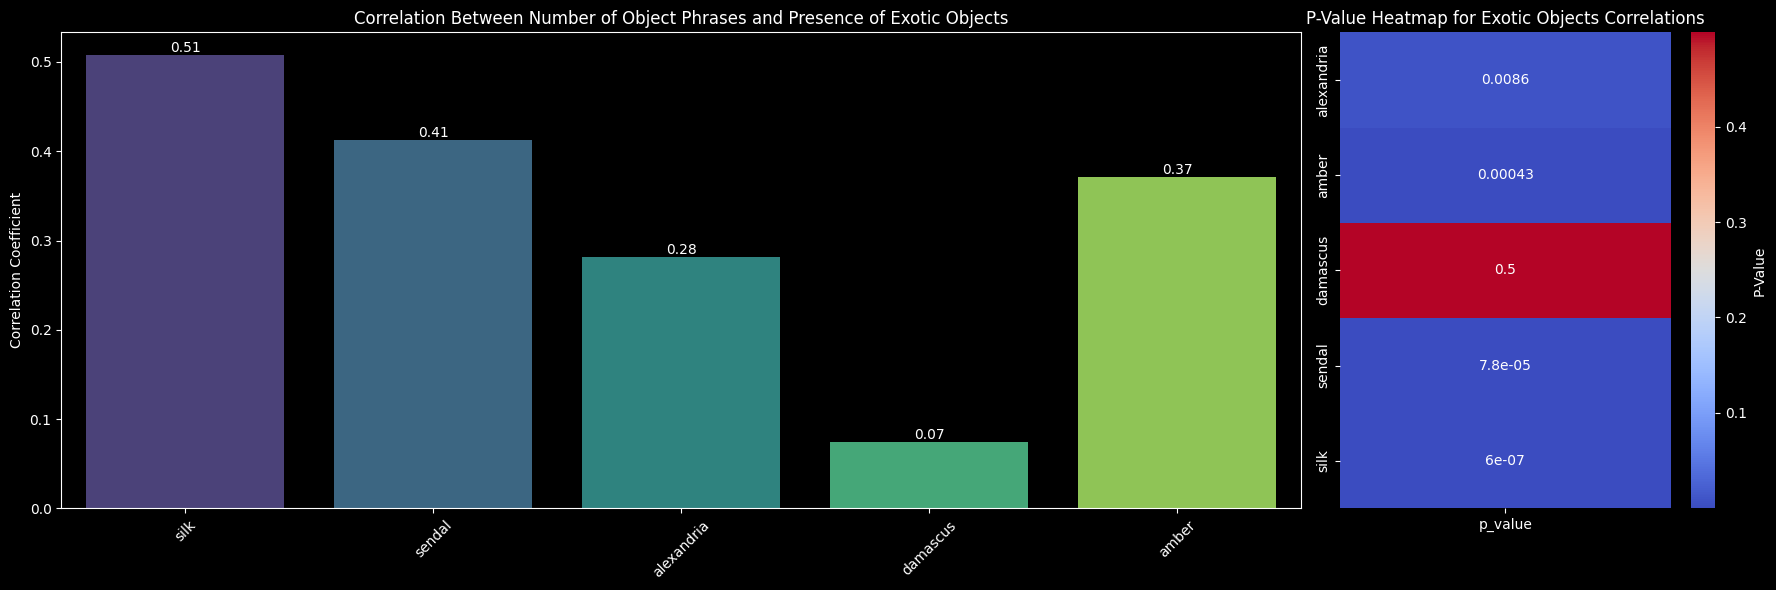

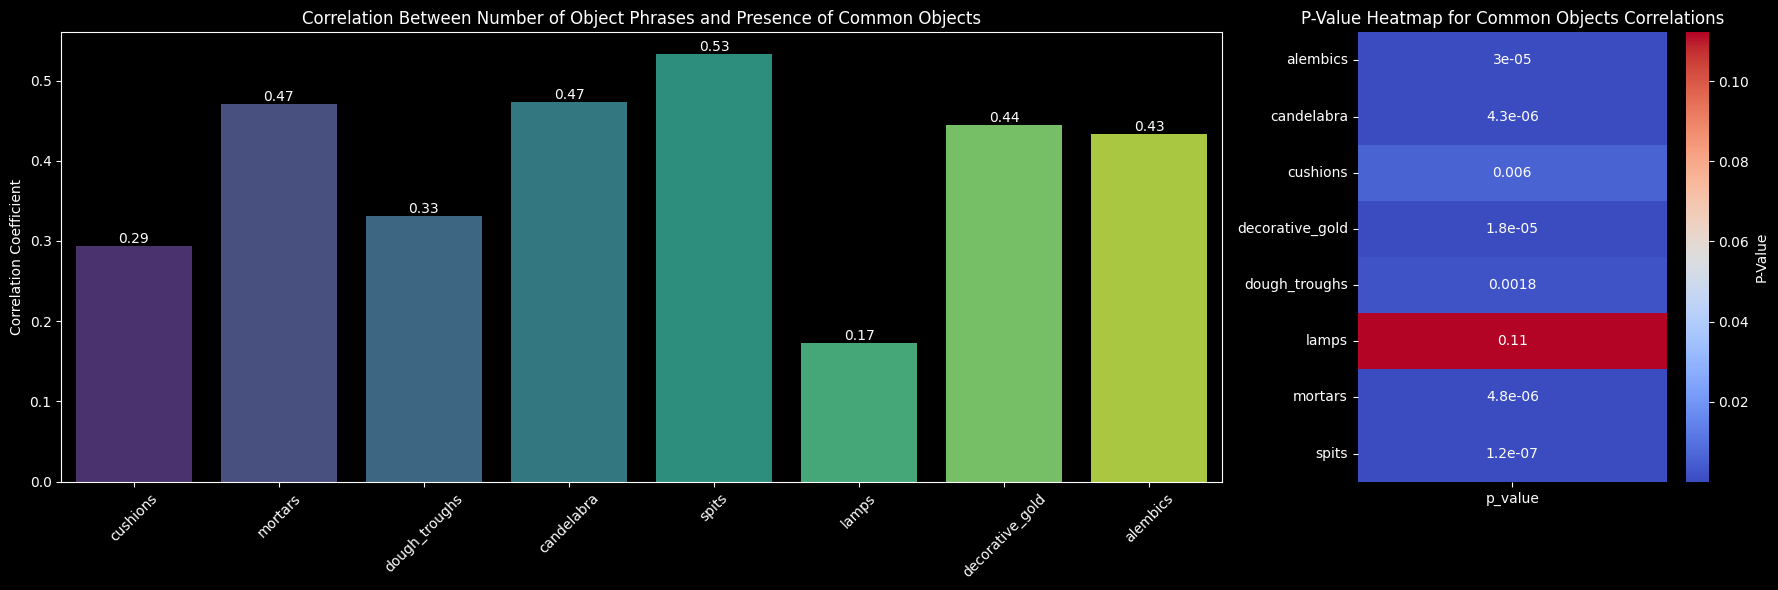

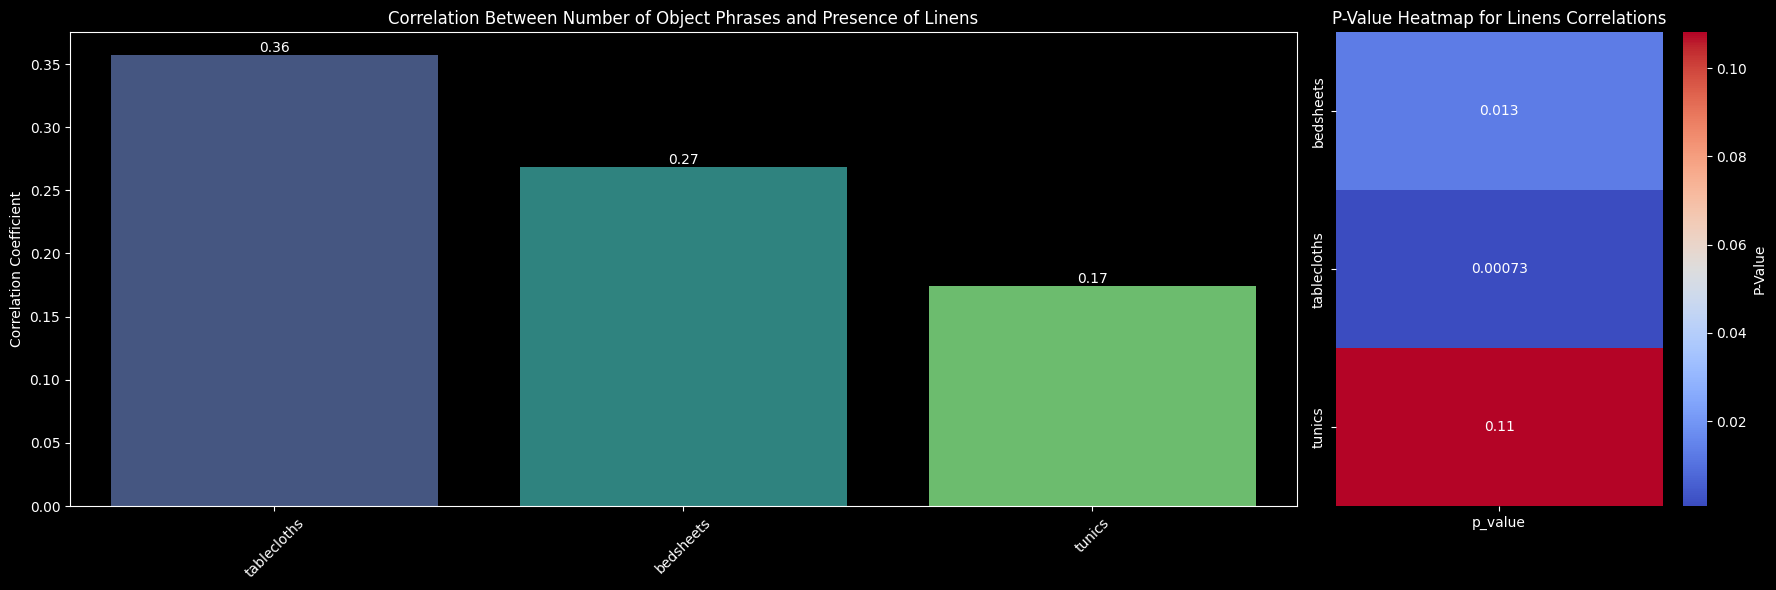

In [26]:
# Calculate correlation coefficients and p-values for object groups
obj_groups = {
    'Dyestuffs': dyestuff_cols,
    'Weapons and Armor': weapons_and_armor_cols,
    'Cushions': cushions_cols,
    'Exotic Objects': exotic_cols,
    'Common Objects': other_objects_cols,
    'Linens': linen_cols,
}

for group_name, group_columns in obj_groups.items():
    columns_to_analyze = group_columns
    correlation_results = []

    # Individual correlations
    for col in columns_to_analyze:
        corr, p_value = pearsonr(df[col], df['object_phrases'])
        correlation_results.append({'column': col, 'correlation': corr, 'p_value': p_value})

    # Convert results to DataFrame
    correlation_df = pd.DataFrame(correlation_results)

    # Visualize correlation results
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6), width_ratios=[3, 1])
    sns.barplot(data=correlation_df, x='column', y='correlation', palette='viridis', ci='sd', ax=ax1)

    for index, row in correlation_df.iterrows():
        ax1.text(index, row['correlation'], f'{row["correlation"]:.2f}', ha='center', va='bottom')

    ax1.set_title(f'Correlation Between Number of Object Phrases and Presence of {group_name}')
    ax1.set_ylabel('Correlation Coefficient')
    ax1.set_xlabel(None)
    ax1.set_xticklabels(correlation_df['column'], rotation=45)
    sns.heatmap(
        correlation_df.pivot_table(index='column', values='p_value'),
        annot=True,
        cmap='coolwarm',
        cbar_kws={'label': 'P-Value'},
        ax=ax2,
    )
    ax2.set_title(f'P-Value Heatmap for {group_name} Correlations')
    ax2.set_xlabel(None)
    ax2.set_ylabel(None)
    plt.tight_layout()
    plt.show()


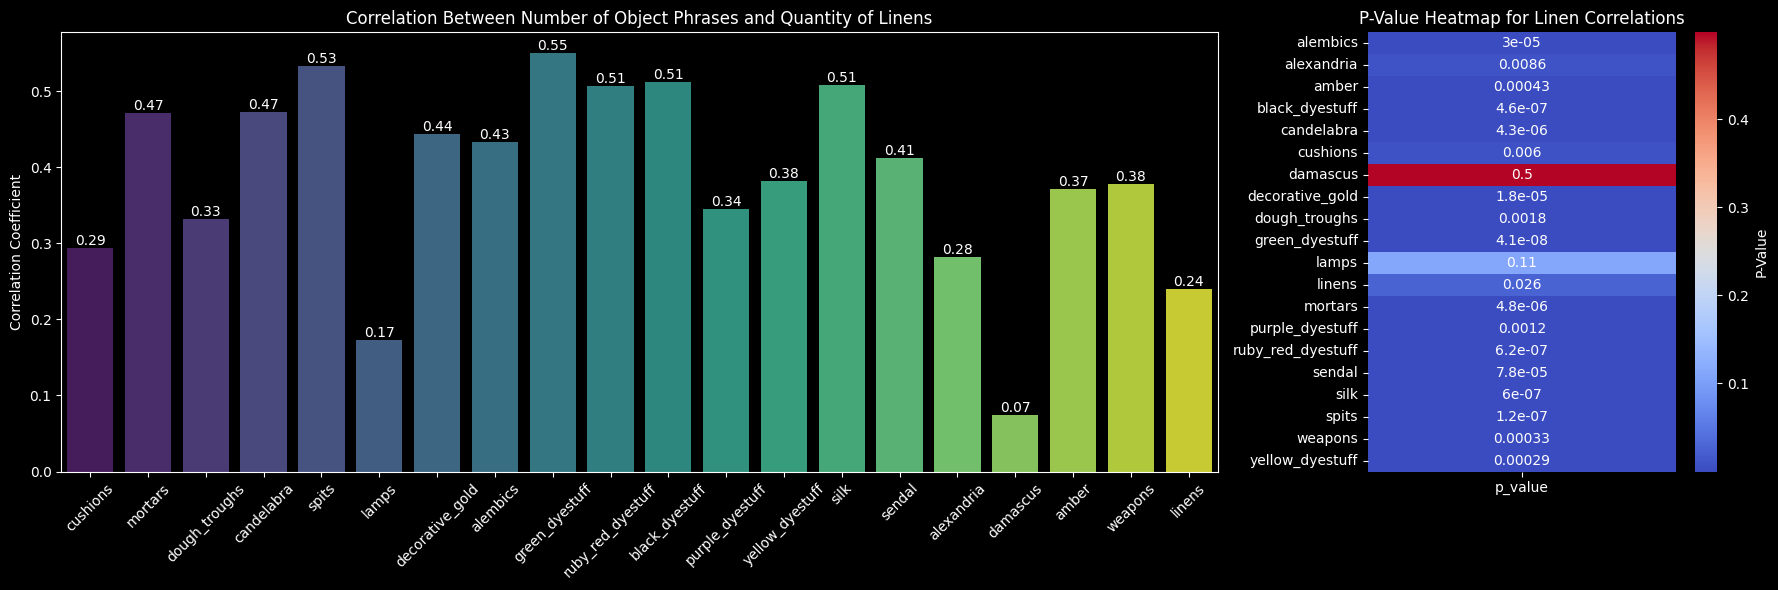

In [29]:
# Calculate correlation coefficients and p-values for total_tablecloths, total_bedsheets, and total_tunics
columns_to_analyze = object_cols
correlation_results = []

# Individual correlations
for col in columns_to_analyze:
    corr, p_value = pearsonr(df[col], df['object_phrases'])
    correlation_results.append({'column': col, 'correlation': corr, 'p_value': p_value})

# Convert results to DataFrame
correlation_df = pd.DataFrame(correlation_results)

# Visualize correlation results
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6), width_ratios=[3, 1])
sns.barplot(data=correlation_df, x='column', y='correlation', palette='viridis', ci='sd', ax=ax1)

for index, row in correlation_df.iterrows():
    ax1.text(index, row['correlation'], f'{row["correlation"]:.2f}', ha='center', va='bottom')

ax1.set_title('Correlation Between Number of Object Phrases and Quantity of Linens')
ax1.set_ylabel('Correlation Coefficient')
ax1.set_xlabel(None)
ax1.set_xticklabels(correlation_df['column'], rotation=45)
sns.heatmap(
    correlation_df.pivot_table(index='column', values='p_value'),
    annot=True,
    cmap='coolwarm',
    cbar_kws={'label': 'P-Value'},
    ax=ax2,
)
ax2.set_title('P-Value Heatmap for Linen Correlations')
ax2.set_xlabel(None)
ax2.set_ylabel(None)
plt.tight_layout()
plt.show()

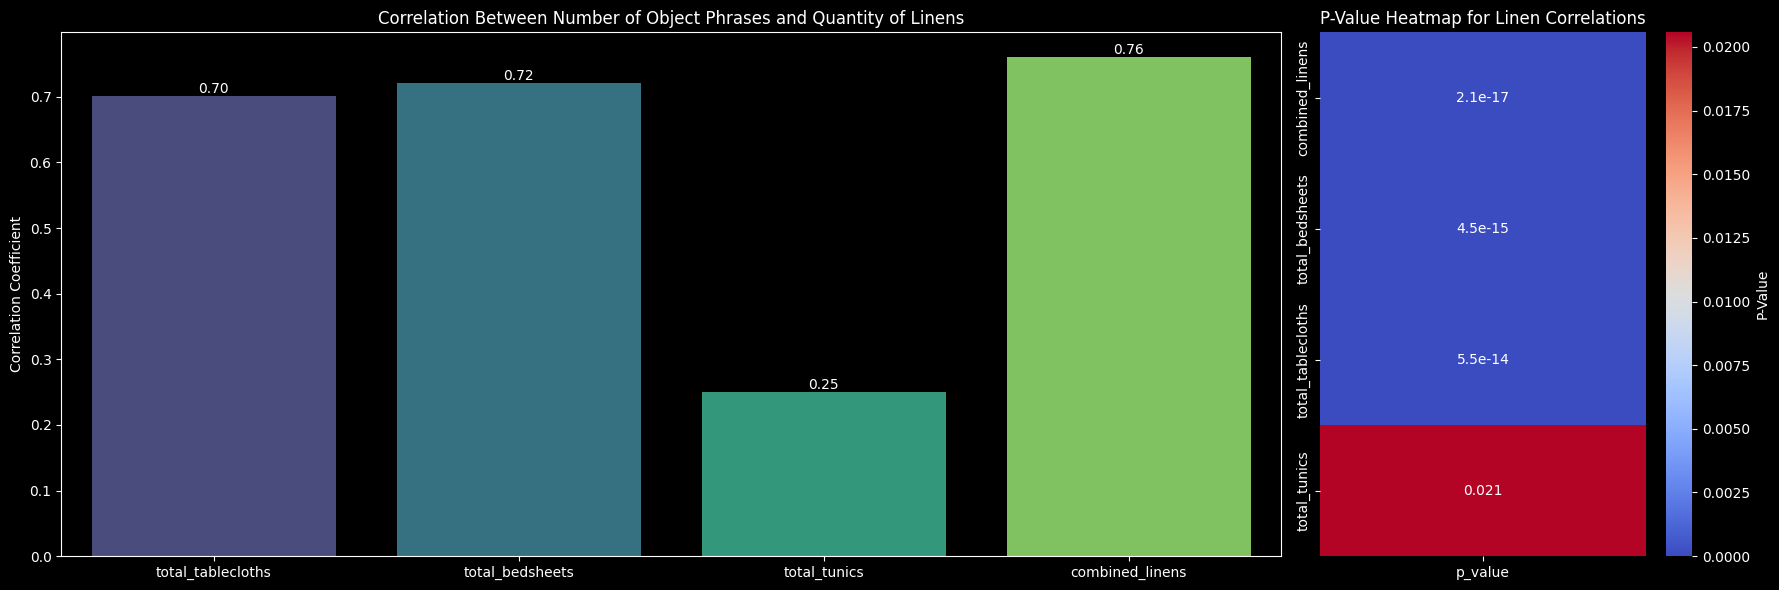

In [30]:
# Calculate correlation coefficients and p-values for total_tablecloths, total_bedsheets, and total_tunics
columns_to_analyze = ['total_tablecloths', 'total_bedsheets', 'total_tunics']
correlation_results = []

# Individual correlations
for col in columns_to_analyze:
    corr, p_value = pearsonr(df[col], df['object_phrases'])
    correlation_results.append({'column': col, 'correlation': corr, 'p_value': p_value})

# Combined correlation (sum of the three columns)
df['combined_linens'] = df['total_tablecloths'] + df['total_bedsheets'] + df['total_tunics']
corr, p_value = pearsonr(df['combined_linens'], df['object_phrases'])
correlation_results.append({'column': 'combined_linens', 'correlation': corr, 'p_value': p_value})

# Convert results to DataFrame
correlation_df = pd.DataFrame(correlation_results)

# Visualize correlation results
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6), width_ratios=[3, 1])
sns.barplot(data=correlation_df, x='column', y='correlation', palette='viridis', ci='sd', ax=ax1)

for index, row in correlation_df.iterrows():
    ax1.text(index, row['correlation'], f'{row["correlation"]:.2f}', ha='center', va='bottom')

ax1.set_title('Correlation Between Number of Object Phrases and Quantity of Linens')
ax1.set_ylabel('Correlation Coefficient')
ax1.set_xlabel(None)
ax1.set_xticklabels(correlation_df['column'])
sns.heatmap(
    correlation_df.pivot_table(index='column', values='p_value'),
    annot=True,
    cmap='coolwarm',
    cbar_kws={'label': 'P-Value'},
    ax=ax2,
)
ax2.set_title('P-Value Heatmap for Linen Correlations')
ax2.set_xlabel(None)
ax2.set_ylabel(None)
plt.tight_layout()
plt.show()


### Interpretation

The analysis shows that textiles, particularly tablecloths and bedsheets, are strong indicators of household wealth *as measured by the number of object phrases in an inventory*. Tunics have a weaker but still significant association. The combined measure of textiles provides the strongest and most statistically significant correlation, reinforcing the idea that textiles as a group are closely tied to the number of object phrases in an inventory.

**Tablecloths:**
- *Correlation:* 0.701 (strong positive correlation)
- *P-value:* 5.58e-14 (highly statistically significant)
- The presence and quantity of tablecloths is strongly and significantly associated with the number of object phrases.

**Bedsheets:**
- *Correlation:* 0.656 (strong positive correlation)
- *P-value:* 7.10e-12 (highly statistically significant)
- The presence and quantity of bedsheets is also strongly and significantly associated with the number of object phrases, though slightly less so than tablecloths.

**Tunics:**
- *Correlation:* 0.250 (weak to moderate positive correlation)
- *P-value:* 2.05e-02 (statistically significant)
- The presence of tunics has a weaker but still significant positive association with the number of object phrases.

**Combined Textiles (sum of tablecloths, bedsheets, and tunics):**
- *Correlation:* 0.733 (strong positive correlation)
- *P-value:* 9.90e-16 (extremely statistically significant)
- When considering all textiles together, the correlation with the number of object phrases is even stronger, suggesting that these metrics are a robust indicator of wealth.


## Do these correlations hold across all time intervals?

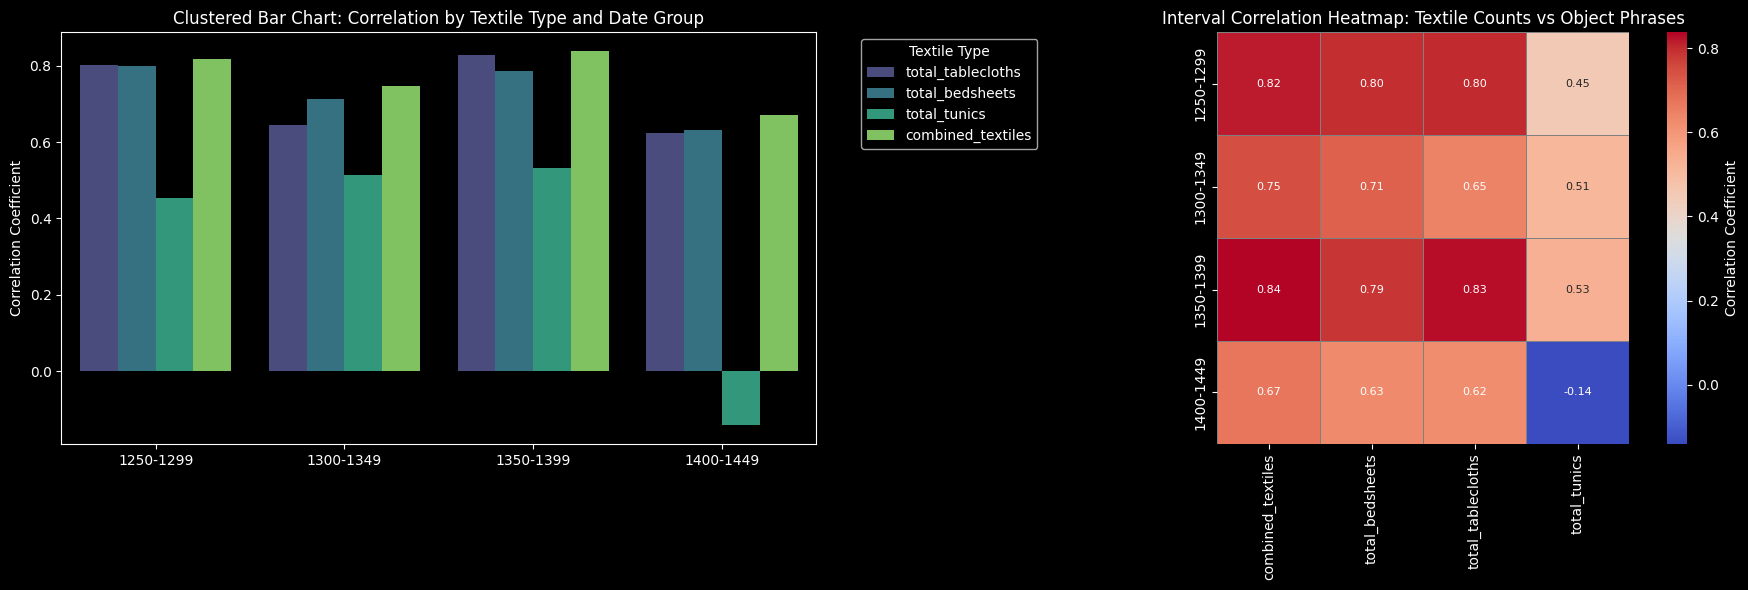

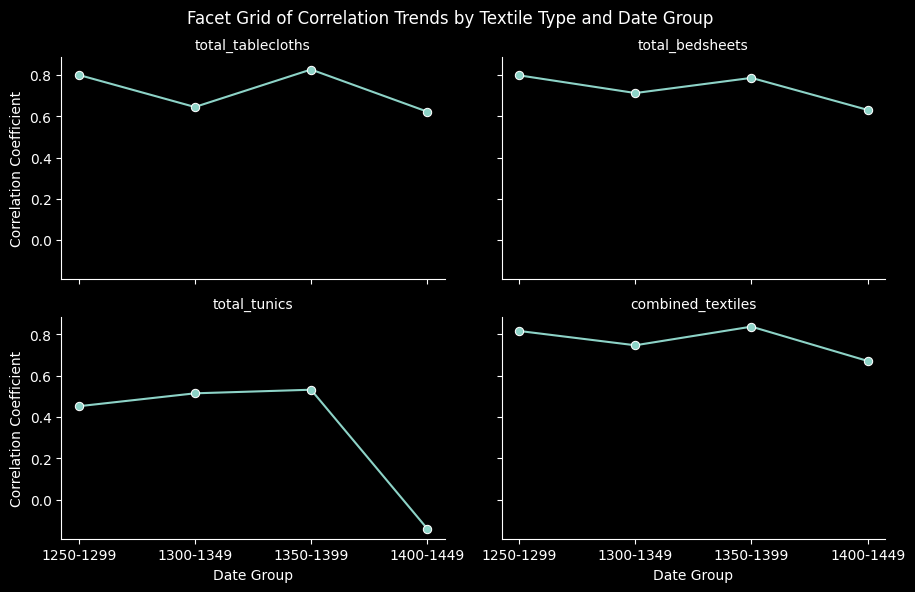

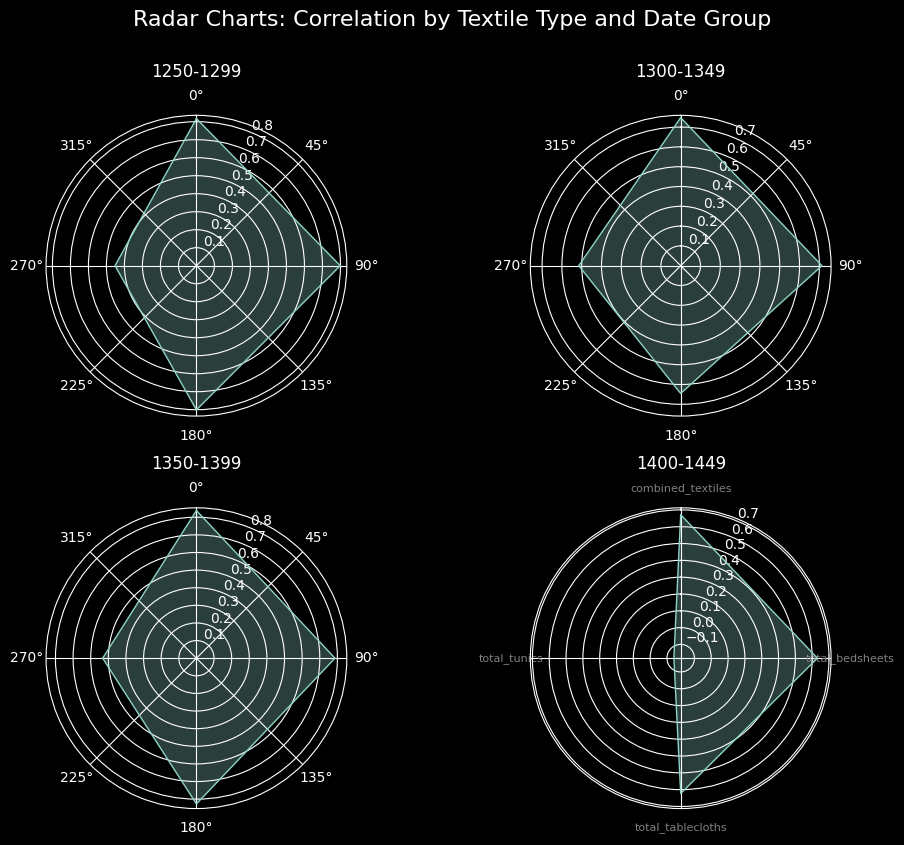

In [32]:
# Repeat the textile correlation analysis for each time interval
interval_correlation_results = []
for group, year_range in date_groupings.items():
    interval_data = df[df['year'].isin(year_range)]
    for col in [*columns_to_analyze, 'combined_textiles']:
        if not interval_data.empty:
            corr, p_value = pearsonr(interval_data[col], interval_data['object_phrases'])
            interval_correlation_results.append(
                {
                    'date_group': group,
                    'column': col,
                    'correlation': corr,
                    'p_value': p_value,
                },
            )

# Convert results to DataFrame
interval_correlation_df = pd.DataFrame(interval_correlation_results)

# Visualize results
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))
sns.barplot(
    data=interval_correlation_df,
    x='date_group',
    y='correlation',
    hue='column',
    palette='viridis',
    ax=ax1,
    dodge=True,
)
ax1.set_title('Clustered Bar Chart: Correlation by Textile Type and Date Group')
ax1.set_xlabel(None)
ax1.set_ylabel('Correlation Coefficient')
ax1.legend(title='Textile Type', bbox_to_anchor=(1.05, 1), loc='upper left')

sns.heatmap(
    interval_correlation_df.pivot(index='date_group', columns='column', values='correlation'),
    annot=True,
    cmap='coolwarm',
    cbar_kws={'label': 'Correlation Coefficient'},
    fmt='.2f',
    linewidths=0.5,
    linecolor='gray',
    square=True,
    mask=interval_correlation_df.pivot(index='date_group', columns='column', values='correlation').isnull(),
    annot_kws={'size': 8},
)
ax2.set_title('Interval Correlation Heatmap: Textile Counts vs Object Phrases')
ax2.set_xlabel(None)
ax2.set_ylabel(None)
plt.tight_layout()
plt.show()

# Facet Grid of Line Plots
facet_data = interval_correlation_df.copy()
facet_data['date_group'] = pd.Categorical(facet_data['date_group'], categories=date_groupings.keys(), ordered=True)
facet_grid = sns.FacetGrid(facet_data, col='column', col_wrap=2, height=3, aspect=1.5, sharey=True, sharex=True)
facet_grid.map(sns.lineplot, 'date_group', 'correlation', marker='o').add_legend()
facet_grid.set_titles(col_template='{col_name}')
facet_grid.set_axis_labels('Date Group', 'Correlation Coefficient')
facet_grid.fig.subplots_adjust(top=0.9)
facet_grid.fig.suptitle('Facet Grid of Correlation Trends by Textile Type and Date Group')
plt.show()

# Radar charts
grid_data = interval_correlation_df.pivot(index='date_group', columns='column', values='correlation')
categories = grid_data.columns.tolist()

fig, axes = plt.subplots(2, 2, subplot_kw={'polar': True}, figsize=(10, 8))
axes = axes.flatten()
for date_group, ax in zip(grid_data.index, axes):
    values = grid_data.loc[date_group].fillna(0).tolist()
    values += values[:1]  # Close the radar chart
    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories, color='grey', size=8)
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=date_group)
    ax.fill(angles, values, alpha=0.3)
    ax.set_title(f'{date_group}', size=12, y=1.1)

plt.tight_layout()
plt.suptitle('Radar Charts: Correlation by Textile Type and Date Group', size=16, y=1.05)
plt.show()


### Interpretation

Tablecloths and bedsheets consistently show strong positive correlations with wealth, *as measured by the number of object phrases in an inventory*, across all time intervals. Tunics have weaker and less consistent correlations, with a negative trend in the 1400-1449 period. Combined textiles provide the strongest and most consistent correlation with the number of object phrases in an inventory. This is particularly true for the period between 1350-1399, perhaps hinting at the change in *object grouping* behaviour observed around 1400.

**Key findings by time interval:**

**1250-1299**
- Tablecloths: Strong positive correlation (0.801), statistically significant (p = 0.003).
- Bedsheets: Strong positive correlation (0.799), statistically significant (p = 0.003).
- Tunics: Moderate positive correlation (0.452), not statistically significant (p = 0.163).
- Combined Textiles: Strong positive correlation (0.817), statistically significant (p = 0.002).
- Tablecloths and bedsheets are strongly correlated to the number of object phrases in this period, while tunics show a weaker and non-significant relationship.

**1300-1349**
- Tablecloths: Strong positive correlation (0.645), statistically significant (p = 0.001).
- Bedsheets: Strong positive correlation (0.713), statistically significant (p < 0.001).
- Tunics: Moderate positive correlation (0.516), statistically significant (p = 0.014).
- Combined Textiles: Strong positive correlation (0.748), statistically significant (p < 0.001).
- All textile types, including tunics, show significant positive correlations with the number of object phrases, with combined textiles being the strongest indicator.

**1350-1399**
- Tablecloths: Very strong positive correlation (0.827), highly significant (p < 0.001).
- Bedsheets: Strong positive correlation (0.787), highly significant (p < 0.001).
- Tunics: Moderate positive correlation (0.533), statistically significant (p = 0.013).
- Combined Textiles: Very strong positive correlation (0.838), highly significant (p < 0.001).
- This period shows the strongest correlations overall, with tablecloths and combined textiles being particularly strong indicators.

**1400-1449**
- Tablecloths: Strong positive correlation (0.623), statistically significant (p < 0.001).
- Bedsheets: Moderate positive correlation (0.455), statistically significant (p = 0.009).
- Tunics: Weak negative correlation (-0.141), not statistically significant (p = 0.441).
- Combined Textiles: Strong positive correlation (0.596), statistically significant (p < 0.001).
- Tablecloths and combined textiles remain strongly correlated to the number of object phrases, while tunics show no significant relationship and even a slight negative trend.


## Does the presence of certain objects correlate with the wealth of a household?

,object_type,correlation,p_value
0,cushions,0.294006,6.003160e-03
1,mortars,0.470874,4.753485e-06
2,dough_troughs,0.331510,1.820918e-03
3,candelabra,0.472762,4.301567e-06
4,spits,0.533376,1.239995e-07
5,lamps,0.172505,1.122268e-01
6,decorative_gold,0.444156,1.837375e-05
7,alembics,0.433773,3.015954e-05
8,green_dyestuff,0.549955,4.143401e-08
9,ruby_red_dyestuff,0.507433,6.153894e-07


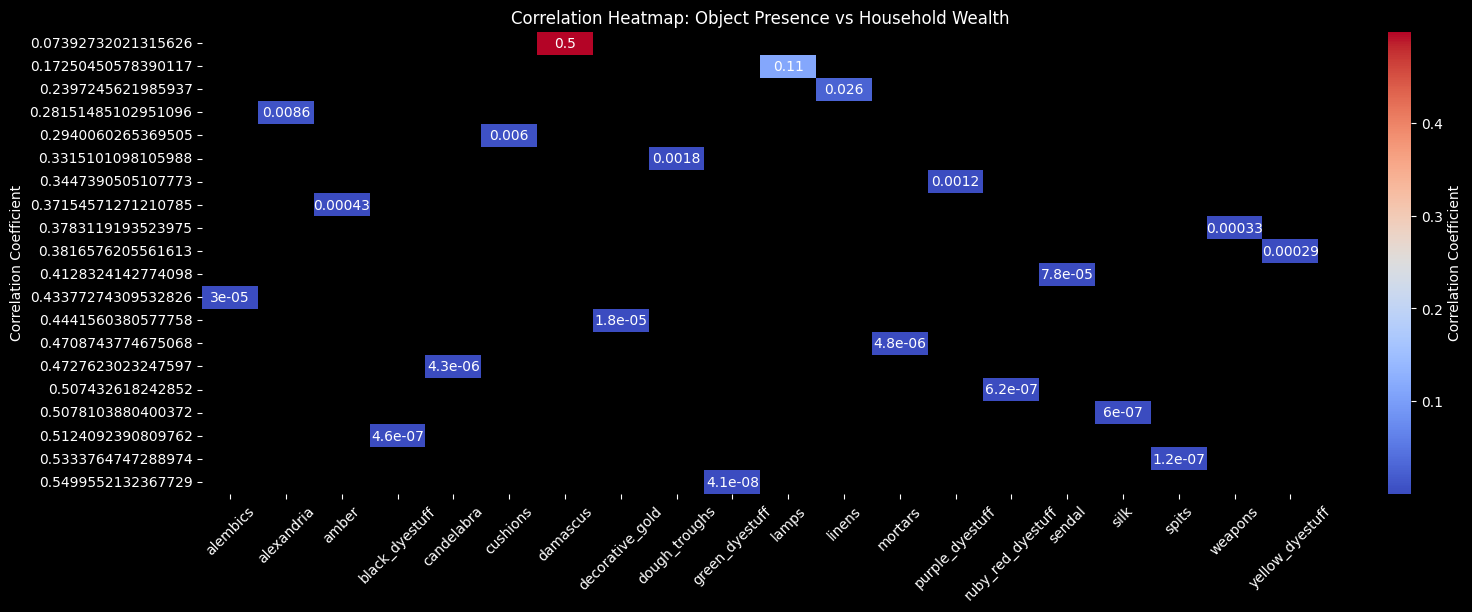

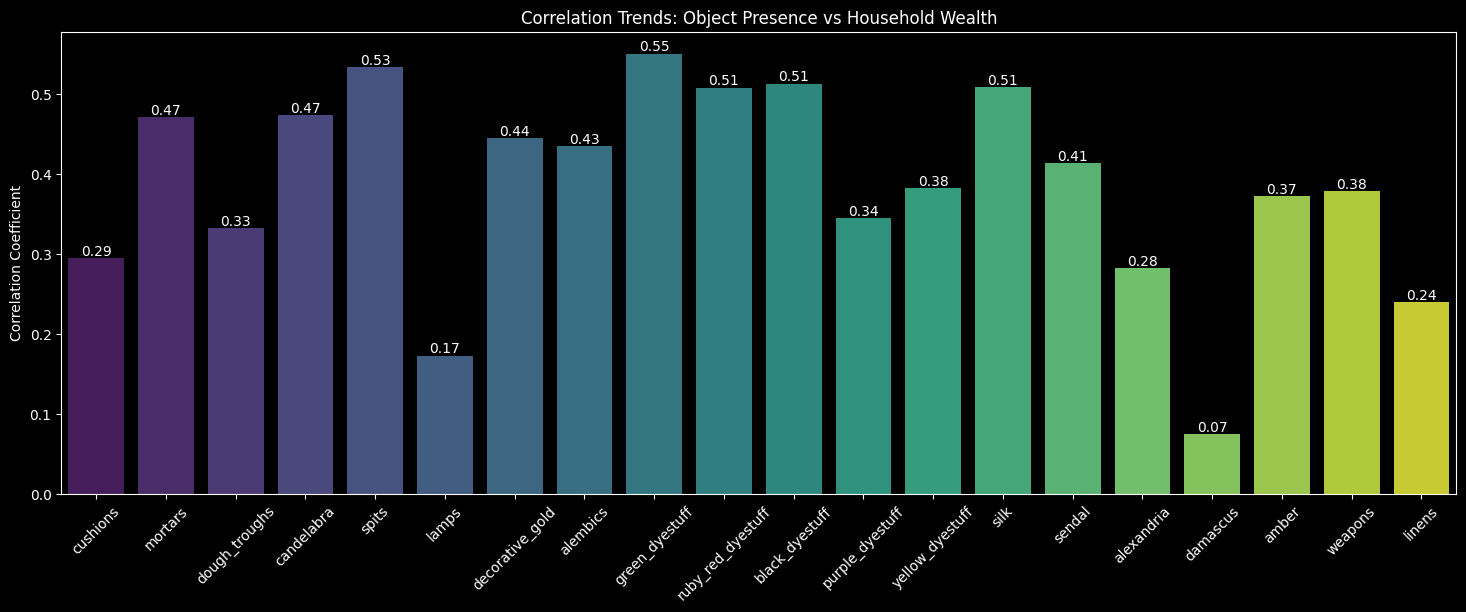

In [36]:
# Calculate correlation coefficients and p-values
correlation_results = []
for col in object_cols:
    corr, p_value = pearsonr(df[col], df['object_phrases'])
    correlation_results.append({'object_type': col, 'correlation': corr, 'p_value': p_value})

# Convert results to DataFrame
correlation_df = pd.DataFrame(correlation_results)

# Display correlation results
display(correlation_df)

# Visualize correlation results
plt.figure(figsize=(18, 6))
sns.heatmap(
    correlation_df.pivot(index='correlation', columns='object_type', values='p_value'),
    annot=True,
    cmap='coolwarm',
    cbar_kws={'label': 'Correlation Coefficient'},
)
plt.title('Correlation Heatmap: Object Presence vs Household Wealth')
plt.xlabel(None)
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.show()

# Lineplot for correlations
plt.figure(figsize=(18, 6))
sns.barplot(data=correlation_df, x='object_type', y='correlation', palette='viridis', ci='sd')

for index, row in correlation_df.iterrows():
    plt.text(index, row['correlation'], f'{row["correlation"]:.2f}', ha='center', va='bottom')

plt.title('Correlation Trends: Object Presence vs Household Wealth')
plt.xlabel(None)
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.show()


### Interpretation

The strongest associations are observed for dyestuffs (*e.g.*, green, ruby-red, black), silk, and spits, which based on these results are statistically significant indicators of household wealth. Objects like candelabra, decorative gold, and alembics also show significant positive correlations but are less strong.
Items like lamps, tunics, and objects associated with Damascus show no significant correlation.

**Strong Positive Correlations (Correlation > 0.5, p-value < 0.05):**
- Green dyestuff (0.549): Strongest correlation with wealth, highly significant (p-value = 4.30e-08).
- Spits (0.533): Strong positive correlation, highly significant (p-value = 1.24e-07).
- Black dyestuff (0.512): Strong positive correlation, highly significant (p-value = 4.61e-07).
- Silk (0.508): Strong positive correlation, highly significant (p-value = 5.86e-07).
- Ruby-red dyestuff (0.507): Strong positive correlation, highly significant (p-value = 6.16e-07).

**Moderate Positive Correlations (0.3 < Correlation ≤ 0.5, p-value < 0.05):**
- Candelabra (0.473)
- Mortars (0.471)
- Decorative gold (0.444)
- Alembics (0.434)
- Sendal (0.412)
- Purple dyestuff (0.345)
- Amber (0.372)
- Yellow dyestuff (0.382)
- Dough troughs (0.332)
- Tablecloths (0.357)
- Cushions (0.294)
- Objects related to Alexandria (0.280)
- Bedsheets (0.268)

**Weak or No Significant Correlations (Correlation ≤ 0.3 or p-value ≥ 0.05):**
- Lamps (0.172, p-value = 0.112), 
- Tunics (0.174, p-value = 0.108), 
- Objects associated with Damascus (0.074, p-value = 0.498).

## Do these results hold across time intervals?


In [ ]:
# Calculate correlation coefficients and p-values for each time interval
def calculate_interval_correlations(df, object_cols, date_groupings):
    """Calculate correlation coefficients and p-values for each object type within specified date groupings."""
    results = []
    for group, year_range in date_groupings.items():
        interval_data = df[df['year'].isin(year_range)]
        for col in object_cols:
            if not interval_data.empty:
                corr, p_value = pearsonr(interval_data[col], interval_data['object_phrases'])
                results.append({'date_group': group, 'object_type': col, 'correlation': corr, 'p_value': p_value})
    return pd.DataFrame(results)


# Perform analysis
interval_correlation_df = calculate_interval_correlations(df, object_cols, date_groupings)

# Display correlation results
display(interval_correlation_df)

# Visualize interval correlation results
plt.figure(figsize=(18, 8))
sns.heatmap(
    interval_correlation_df.pivot(index='date_group', columns='object_type', values='correlation'),
    annot=True,
    cmap='coolwarm',
    cbar_kws={'label': 'Correlation Coefficient'},
)
plt.title('Interval Correlation Heatmap: Object Presence vs Household Wealth')
plt.xlabel(None)
plt.ylabel(None)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Lineplot for interval correlations
plt.figure(figsize=(18, 8))
sns.lineplot(data=interval_correlation_df, x='object_type', y='correlation', hue='date_group', marker='o')
plt.title('Interval Correlation Trends: Object Presence vs Household Wealth')
plt.xlabel(None)
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.legend(title='Date Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.2)  # noqa: FBT003
plt.tight_layout()
plt.show()

# Lineplot for interval correlations
plt.figure(figsize=(18, 8))
sns.lineplot(data=interval_correlation_df, x='date_group', y='correlation', hue='object_type', marker='o')
plt.title('Interval Correlation Trends: Object Presence vs Household Wealth')
plt.xlabel(None)
plt.ylabel('Correlation Coefficient')
plt.legend(title='Object Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.2)  # noqa: FBT003
plt.tight_layout()
plt.show()


### Interpretation

Gold in decorative items or jewelry, spits, green dyestuff, and silk consistently show strong positive correlations with wealth across multiple time intervals. Black dyestuff, Amber, and Candelabra also show significant correlations but vary in strength across periods. Objects like lamps, tunics, and items related to Dmascus generally show weak or no significant correlations with wealth.

**Key findings by time interval:**

**1250-1299**

*Strong Positive Correlations (Correlation > 0.6, p-value < 0.05):*
- Decorative gold (0.915, p = 0.000077): The strongest indicator of wealth in this period.
- Ruby-red dyestuff (0.688, p = 0.019): Strongly associated with wealth.
- Candelabra (0.667, p = 0.025): Significant positive correlation.
- Yellow dyestuff (0.648, p = 0.031): Significant positive correlation.
- Objects related to Alexandria (0.665, p = 0.025): Strong positive correlation.

*Weak or No Significant Correlations:*
- Spits (-0.054, p = 0.876): No significant correlation.
- Lamps (0.051, p = 0.883): No significant correlation.
- Sendal (-0.133, p = 0.697): No significant correlation.

**1300-1349**

*Strong Positive Correlations (Correlation > 0.6, p-value < 0.05):*
- Black dyestuff (0.734, p = 0.0001): The strongest indicator of wealth in this period.
- Mortar (0.707, p = 0.0002): Strongly associated with wealth.
- Sendal (0.702, p = 0.0003): Strong positive correlation.
- Green dyestuff (0.619, p = 0.002): Significant positive correlation.

*Moderate Positive Correlations (0.3 < Correlation ≤ 0.6, p-value < 0.05):*
- Candelabra (0.567, p = 0.006): Moderate positive correlation.
- Amber (0.539, p = 0.010): Moderate positive correlation.
- Yellow dyestuff (0.533, p = 0.011): Moderate positive correlation.

*Weak or No Significant Correlations:*
- Lamps (0.098, p = 0.663): No significant correlation.
- Tunics (0.039, p = 0.862): No significant correlation.

**1350-1399**

*Strong Positive Correlations (Correlation > 0.6, p-value < 0.05):*
- Spits (0.774, p = 0.00004): The strongest indicator of wealth in this period.
- Green dyestuff (0.650, p = 0.001): Strongly associated with wealth.
- Silk (0.647, p = 0.001): Strong positive correlation.
- Alembics (0.606, p = 0.004): Significant positive correlation.

*Moderate Positive Correlations (0.3 < Correlation ≤ 0.6, p-value < 0.05):*
- Black dyestuff (0.561, p = 0.008): Moderate positive correlation.
- Sendal (0.545, p = 0.011): Moderate positive correlation.
- Yellow dyestuff (0.527, p = 0.014): Moderate positive correlation.

*Weak or No Significant Correlations:*
- Amber (-0.026, p = 0.912): No significant correlation.
- Lamps (-0.028, p = 0.904): No significant correlation.

**1400-1449**

*Strong Positive Correlations (Correlation > 0.6, p-value < 0.05):*
- Spits (0.637, p = 0.0001): The strongest indicator of wealth in this period.
- Green dyestuff (0.581, p = 0.0005): Strongly associated with wealth.

*Moderate Positive Correlations (0.3 < Correlation ≤ 0.6, p-value < 0.05):*

- Silk (0.515, p = 0.003): Moderate positive correlation.
- Amber (0.560, p = 0.001): Moderate positive correlation.
- Purple dyestuff (0.544, p = 0.001): Moderate positive correlation.

*Weak or No Significant Correlations:*
- Tunics (-0.146, p = 0.425): No significant correlation.
- Yellow dyestuff (0.200, p = 0.273): No significant correlation.


## Are there significant differences in these patterns between the most (top quartile) and less wealthy (bottom quartile) households?

In [ ]:
# Compare top and bottom quartiles of household wealth
def calculate_quartile_correlations(df, object_cols, date_groupings):
    """Calculate correlation coefficients and p-values for top and bottom quartiles of household wealth."""
    results = []
    for group, year_range in date_groupings.items():
        interval_data = df[df['year'].isin(year_range)]
        if not interval_data.empty:
            # Calculate top and bottom quartiles
            top_quartile = interval_data[
                interval_data['object_phrases'] >= interval_data['object_phrases'].quantile(0.75)
            ]
            bottom_quartile = interval_data[
                interval_data['object_phrases'] <= interval_data['object_phrases'].quantile(0.25)
            ]

            for quartile, data in zip(['Top Quartile', 'Bottom Quartile'], [top_quartile, bottom_quartile]):
                for col in object_cols:
                    if not data.empty:
                        corr, p_value = pearsonr(data[col], data['object_phrases'])
                        results.append(
                            {
                                'date_group': group,
                                'quartile': quartile,
                                'object_type': col,
                                'correlation': corr,
                                'p_value': p_value,
                            },
                        )
    return pd.DataFrame(results)


# Perform analysis for top and bottom quartiles
quartile_correlation_df = calculate_quartile_correlations(df, object_cols, date_groupings)

# Display correlation results for quartiles
display(quartile_correlation_df)

# Visualize quartile correlation results
plt.figure(figsize=(18, 8))
sns.heatmap(
    quartile_correlation_df.pivot(index=['date_group', 'quartile'], columns='object_type', values='correlation'),
    annot=True,
    cmap='coolwarm',
    cbar_kws={'label': 'Correlation Coefficient'},
)
plt.title('Quartile Correlation Heatmap: Object Presence vs Household Wealth')
plt.xlabel(None)
plt.ylabel(None)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Prepare data for facet grid
facet_data = quartile_correlation_df.copy()
facet_data['date_group'] = pd.Categorical(facet_data['date_group'], categories=date_groupings.keys(), ordered=True)
facet_grid = sns.FacetGrid(
    facet_data,
    col='object_type',
    hue='quartile',
    col_wrap=3,
    height=4,
    aspect=1,
    sharey=True,
    sharex=True,
)

facet_grid.map(sns.lineplot, 'date_group', 'correlation', marker='o').add_legend()
facet_grid.set_titles(col_template='{col_name}')
facet_grid.set_axis_labels('Date Group', 'Correlation Coefficient')
facet_grid.fig.subplots_adjust(top=0.9)
facet_grid.fig.suptitle('Facet Grid of Correlation Trends by Quartile and Object Type')
plt.show()


### Interpretation

Overall, there's not enough data in the sample for this type of analysis, as indicated but the abundance of `NaN` values for many of the object types in specific quartiles and time intervals. Most objects show weak to moderate correlations with wealth, but these are generally not statistically significant. In terms of comparing top and bottom quartiles, the top quartile often shows weak or no significant correlations, with occasional moderate correlations for objects like decorative gold and alembics, while the bottom quartile occasionally shows moderate correlations for objects like mortars, dough troughs, and bedsheets, but these are not statistically significant.

**Key findings by time interval:**

Across the board most objects show weak or no significant correlations due to insufficient data.

**1250-1299**

*Top Quartile:*
- Spits (-0.993, p = 0.076): Strong negative correlation, but not statistically significant.
- Lamps (-0.993, p = 0.076): Strong negative correlation, but not statistically significant.

*Bottom Quartile:*
- Mortars (0.980, p = 0.129): Moderate positive correlation, but not statistically significant.
- Tablecloths (0.980, p = 0.129): Moderate positive correlation, but not statistically significant.

**1300-1349**

*Top Quartile:*
- Decorative gold (0.488, p = 0.326): Moderate positive correlation, but not statistically significant.
- Purple dyestuff (0.488, p = 0.326): Moderate positive correlation, but not statistically significant.
- Lamps (0.471, p = 0.345): Weak positive correlation, but not statistically significant.

*Bottom Quartile:*
- Spits (0.462, p = 0.297): Weak positive correlation, but not statistically significant.
- Cushions (0.430, p = 0.336): Weak positive correlation, but not statistically significant.

**1350-1399**

*Top Quartile:*
- Alembic (0.591, p = 0.217): Moderate positive correlation, but not statistically significant.
- Ruby-red dyestuff (0.491, p = 0.322): Weak positive correlation, but not statistically significant.

*Bottom Quartile:*
- Mortars (0.640, p = 0.171): Moderate positive correlation, but not statistically significant.
- Dough troughs (0.640, p = 0.171): Moderate positive correlation, but not statistically significant.

**1400-1449**

*Top Quartile:*
- Decorative gold (0.644, p = 0.085): Moderate positive correlation, but not statistically significant.
- Amber (0.559, p = 0.150): Moderate positive correlation, but not statistically significant.

*Bottom Quartile:*
- Bedsheets (0.605, p = 0.112): Moderate positive correlation, but not statistically significant.
- Tunics (0.444, p = 0.270): Weak positive correlation, but not statistically significant.


## Can we detect changes in household wealth across time?

In [ ]:
# Calculate average household wealth by year
average_wealth_by_year = df.groupby('year')['object_phrases'].mean().reset_index()

# Add interval trendlines to the chart
plt.figure(figsize=(18, 8))
sns.lineplot(data=average_wealth_by_year, x='year', y='object_phrases', marker='o', label='By Year', linewidth=1)


# Add linear trendlines for each interval
def add_linear_trendlines(ax, date_groupings, df):
    """Add linear trendlines for each date grouping."""
    for group, year_range in date_groupings.items():
        interval_data = df[df['year'].isin(year_range)].groupby('year')['object_phrases'].mean().reset_index()
        if not interval_data.empty:
            # Fit a linear trendline
            p = Polynomial.fit(interval_data['year'], interval_data['object_phrases'], 1)
            trendline = p(interval_data['year'])
            ax.plot(interval_data['year'], trendline, linestyle='--', linewidth=3, label=f'Linear Trendline {group}')


ax = plt.gca()
add_linear_trendlines(ax, date_groupings, df)

plt.title('Changes in Average Household Wealth Over Time with Linear Trendlines')
plt.xlabel(None)
plt.ylabel('Average Household Wealth')
plt.legend(title='Grouping')
plt.grid(True, alpha=0.2)  # noqa: FBT003
plt.tight_layout()
plt.show()


In [ ]:
# Calculate weighted average household wealth by year
weighted_wealth_by_year = (
    df.groupby('year').apply(lambda x: (x['object_phrases'] * x['id'].count()).sum() / x['id'].count()).reset_index()
)
weighted_wealth_by_year.columns = ['year', 'weighted_average_wealth']

# Plot weighted average household wealth by year
plt.figure(figsize=(18, 8))
sns.lineplot(
    data=weighted_wealth_by_year,
    x='year',
    y='weighted_average_wealth',
    marker='o',
    label='Weighted Average Wealth',
    linewidth=1,
)


# Add linear trendlines for each interval
def add_linear_trendlines(ax, date_groupings, df):
    """Add linear trendlines for each date grouping."""
    for group, year_range in date_groupings.items():
        interval_data = df[df['year'].isin(year_range)].groupby('year')['object_phrases'].mean().reset_index()
        if not interval_data.empty:
            # Fit a linear trendline
            p = Polynomial.fit(interval_data['year'], interval_data['object_phrases'], 1)
            trendline = p(interval_data['year'])
            ax.plot(interval_data['year'], trendline, linestyle='--', linewidth=3, label=f'Linear Trendline {group}')


ax = plt.gca()
add_linear_trendlines(ax, date_groupings, df)

plt.title('Changes in Weighted Average Household Wealth Over Time with Linear Trendlines')
plt.xlabel(None)
plt.ylabel('Weighted Average Household Wealth')
plt.legend(title='Grouping')
plt.grid(True, alpha=0.2)  # noqa: FBT003
plt.tight_layout()
plt.show()


## Clustering

In [ ]:
# Select relevant columns for clustering
clustering_columns = [
    *object_cols,
    'object_phrases',
    'total_tablecloths',
    'total_bedsheets',
    'total_tunics',
    'faith',
    'gender_decedent',
]
data_for_clustering = df[clustering_columns].fillna(0)

# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data_for_clustering)


In [ ]:
# Compare methods to determine the optimal number of clusters
cluster_range = range(2, 11)  # Test cluster sizes from 2 to 10
# Create subplots for different clustering methods
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(18, 18))
axes = axes.flatten()

results = []

# silhouette score
silhouette_scores = []
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(normalized_data)
    silhouette_avg = silhouette_score(normalized_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

results.append(('Silhouette', cluster_range[np.argmax(silhouette_scores)]))

# Visualize silhouette scores
sns.lineplot(x=cluster_range, y=silhouette_scores, marker='o', ax=axes[0])
axes[0].set_title('Silhouette Scores for Different Numbers of Clusters')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Silhouette Score')
axes[0].grid(True, alpha=0.2)  # noqa: FBT003
# highlight the optimal number of clusters
axes[0].axvline(
    x=cluster_range[np.argmax(silhouette_scores)],
    color='red',
    linestyle='--',
    label='Optimal Number of Clusters',
)
axes[0].legend()

# Elbow Method
wcss = []
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(normalized_data)
    wcss.append(kmeans.inertia_)

elbow_point = cluster_range[np.argmax(np.diff(wcss, 2)) + 2]  # + 2 to adjust for the first two points
results.append(('Elbow', elbow_point))

# Visualize WCSS
sns.lineplot(x=cluster_range, y=wcss, marker='o', ax=axes[1])
axes[1].set_title('Elbow Method')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('WCSS')
axes[1].grid(True, alpha=0.2)  # noqa: FBT003
# highlight the elbow point
axes[1].axvline(x=elbow_point, color='red', linestyle='--', label='Optimal Number of Clusters')
axes[1].legend()

# Davies-Bouldin Index
db_scores = []
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(normalized_data)
    db_scores.append(davies_bouldin_score(normalized_data, cluster_labels))

results.append(('Davies-Bouldin', cluster_range[np.argmin(db_scores)]))

# Visualize Davies-Bouldin Index
sns.lineplot(x=cluster_range, y=db_scores, marker='o', ax=axes[2])
axes[2].set_title('Davies-Bouldin Index')
axes[2].set_xlabel('Number of Clusters')
axes[2].set_ylabel('DB Index')
axes[2].grid(True, alpha=0.2)  # noqa: FBT003
# highlight the optimal number of clusters
axes[2].axvline(x=cluster_range[np.argmin(db_scores)], color='red', linestyle='--', label='Optimal Number of Clusters')
axes[2].legend()

# Calinski-Harabasz Index
ch_scores = []
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(normalized_data)
    ch_scores.append(calinski_harabasz_score(normalized_data, cluster_labels))

results.append(('Calinski-Harabasz', cluster_range[np.argmax(ch_scores)]))

# Visualize Calinski-Harabasz Index
sns.lineplot(x=cluster_range, y=ch_scores, marker='o', ax=axes[3])
axes[3].set_title('Calinski-Harabasz Index')
axes[3].set_xlabel('Number of Clusters')
axes[3].set_ylabel('CH Index')
axes[3].grid(True, alpha=0.2)  # noqa: FBT003
# highlight the optimal number of clusters
axes[3].axvline(x=cluster_range[np.argmax(ch_scores)], color='red', linestyle='--', label='Optimal Number of Clusters')
axes[3].legend()

# BIC/AIC using Gaussian Mixture Models
bic_scores = []
aic_scores = []
for n_clusters in cluster_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(normalized_data)
    bic_scores.append(gmm.bic(normalized_data))
    aic_scores.append(gmm.aic(normalized_data))

results.append(('BIC', cluster_range[np.argmin(bic_scores)]))
results.append(('AIC', cluster_range[np.argmin(aic_scores)]))

# Visualize BIC and AIC
sns.lineplot(x=cluster_range, y=bic_scores, marker='o', label='BIC', ax=axes[4])
sns.lineplot(x=cluster_range, y=aic_scores, marker='o', label='AIC', ax=axes[4])
axes[4].set_title('BIC and AIC for Gaussian Mixture Models')
axes[4].set_xlabel('Number of Clusters')
axes[4].set_ylabel('Score')
axes[4].legend()
axes[4].grid(True, alpha=0.2)  # noqa: FBT003
# highlight the optimal number of clusters for BIC and AIC
axes[4].axvline(x=cluster_range[np.argmin(bic_scores)], color='red', linestyle='--', label='Optimal BIC Clusters')
axes[4].axvline(x=cluster_range[np.argmin(aic_scores)], color='blue', linestyle='--', label='Optimal AIC Clusters')
axes[4].legend()

# Dendrogram for Hierarchical Clustering
linked = linkage(normalized_data, method='ward')
dendrogram(
    linked,
    truncate_mode='lastp',
    p=10,
    leaf_rotation=45.0,
    leaf_font_size=12.0,
    show_contracted=True,
    ax=axes[5],
)

clusters = fcluster(linked, t=28, criterion='distance')
results.append(('Hierarchical', len(set(clusters))))

# Visualize Dendrogram
axes[5].set_title('Dendrogram for Hierarchical Clustering')
axes[5].set_xlabel('Cluster Size')
axes[5].set_ylabel('Distance')
axes[5].grid(True, alpha=0.2)  # noqa: FBT003

plt.tight_layout()
plt.suptitle('Clustering Method Comparison', size=16, y=1.02)
plt.show()

# Display clustering results
results_df = pd.DataFrame(results, columns=['Method', 'Optimal Number of Clusters'])
# make results integers
results_df['Optimal Number of Clusters'] = results_df['Optimal Number of Clusters'].astype(int)
display(results_df)


In [ ]:
# optimal number of clusters as the mode of the optimal clusters from different methods
optimal_clusters = results_df['Optimal Number of Clusters'].mode()[0]
print(f'Optimal number of clusters determined by majority vote: {optimal_clusters}')

# Perform clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(normalized_data)

# Display the number of records in each cluster
cluster_counts = df['cluster'].value_counts().sort_index()
print('Cluster counts:')
print(cluster_counts)

# Reduce dimensions for visualization using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(normalized_data)
df['pca_x'] = reduced_data[:, 0]
df['pca_y'] = reduced_data[:, 1]

# Scatter plot of clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='pca_x', y='pca_y', hue='cluster', palette='viridis', s=100, alpha=0.7)
plt.title('Cluster Visualization (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.2)  # noqa: FBT003
plt.tight_layout()
plt.show()

# Display cluster members as a table
for cluster_id in sorted(df['cluster'].unique()):
    cluster_members = df[df['cluster'] == cluster_id]
    print(f'Cluster {cluster_id} Members:')
    display(cluster_members[['id', 'year', 'cluster']])


In [ ]:
# Analyze date group representation in each cluster
date_group_distribution = df.groupby(['cluster', 'date_group']).size().unstack(fill_value=0)

# Stacked Bar Chart
date_group_distribution.T.plot(kind='bar', stacked=True, colormap='berlin', figsize=(12, 8))
plt.title('Stacked Bar Chart: Date Group Representation in Clusters')
plt.xlabel('Date Group')
plt.ylabel('Count')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print the distribution as a table
print('Date Group Distribution Across Clusters:')
display(date_group_distribution)